# 1. Install Required Libraries and Download the Dataset

In [ ]:
# Install required libraries
!pip install gdown
import gdown
import zipfile
import os

# Download the dataset
url = 'https://drive.google.com/uc?id=1UYIwee2hx6g8FYt5ILXcBOap_qADQ6M9'
output = 'lumbar_dataset.zip'
gdown.download(url, output, quiet=False)

# Extract the dataset
with zipfile.ZipFile('lumbar_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('lumbar_dataset')

print("Dataset extracted successfully.")


Downloading...
From (original): https://drive.google.com/uc?id=1UYIwee2hx6g8FYt5ILXcBOap_qADQ6M9
From (redirected): https://drive.google.com/uc?id=1UYIwee2hx6g8FYt5ILXcBOap_qADQ6M9&confirm=t&uuid=6489dc9a-20ee-4731-9031-d1530cca5a8c
To: /content/lumbar_dataset.zip
100%|██████████| 752M/752M [00:20<00:00, 37.4MB/s]


Dataset extracted successfully.


# 2. Visualize the Data

*   2.1 Visualize Some Images from Each Class

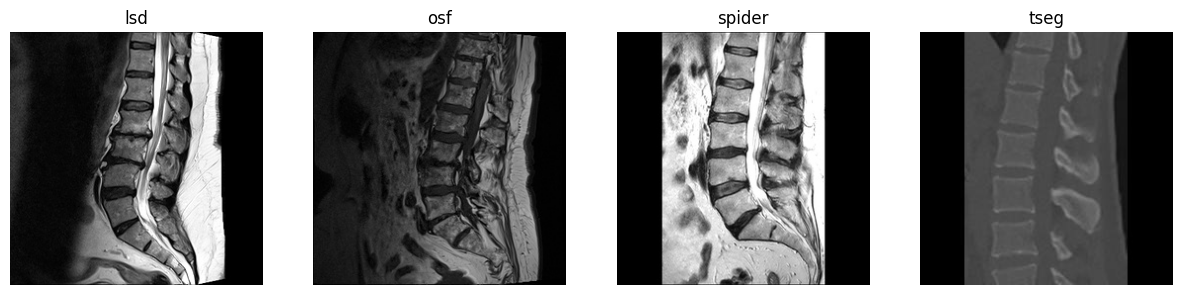

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Visualize some images from each class
def visualize_sample_images(data_dir, class_names):
    fig, axes = plt.subplots(1, len(class_names), figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, f'processed_{class_name}_jpgs')
        img_name = os.listdir(class_dir)[0]
        img = cv2.imread(os.path.join(class_dir, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis('off')
    plt.show()

# Define class names
class_names = ['lsd', 'osf', 'spider', 'tseg']
visualize_sample_images('lumbar_dataset/data', class_names)


*   2.2 Visualize the Distribution of Classes

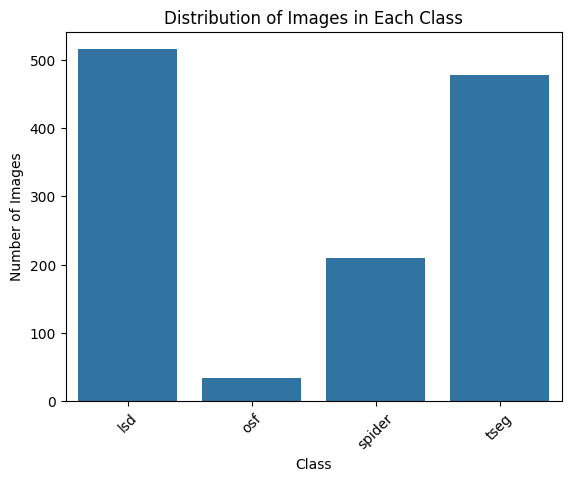

In [ ]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Count the number of images in each class
def visualize_class_distribution(data_dir, class_names):
    class_counts = {}
    for class_name in class_names:
        class_dir = os.path.join(data_dir, f'processed_{class_name}_jpgs')
        class_counts[class_name] = len(os.listdir(class_dir))

    # Convert the class counts into a pandas DataFrame for visualization
    df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Number of Images'])

    # Create a bar plot using seaborn
    sns.barplot(x='Class', y='Number of Images', data=df)
    plt.title('Distribution of Images in Each Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)  # Rotate the x-axis labels if needed for readability
    plt.show()

# Visualize the distribution
visualize_class_distribution('lumbar_dataset/data', class_names)


# 3. Preprocess and Load Data

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Load and preprocess the data
def load_and_preprocess_data(data_dir, img_size=(224, 224)):
    images = []
    labels = []
    class_names = ['lsd', 'osf', 'spider', 'tseg']
    for class_name in class_names:
        class_dir = os.path.join(data_dir, f'processed_{class_name}_jpgs')
        class_label = class_names.index(class_name)
        for img_name in tqdm(os.listdir(class_dir), desc=f"Loading {class_name}"):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize pixel values
            images.append(img)
            labels.append(class_label)
    return np.array(images), np.array(labels)

# Load the data
X, y = load_and_preprocess_data('lumbar_dataset/data')

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

print(f"Train set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


Loading tseg: 100%|██████████| 478/478 [00:01<00:00, 262.37it/s]


Train set shape: (791, 224, 224, 3)
Validation set shape: (198, 224, 224, 3)
Test set shape: (248, 224, 224, 3)


# 4. Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Fit the ImageDataGenerator on the training data
datagen.fit(X_train)


# 5. Define the Pre-trained Models (MobileNet)

In [ ]:
import tensorflow as tf  # Added import for TensorFlow
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Helper function to create transfer learning model
def create_transfer_learning_model(base_model, input_shape, num_classes):
    base_model.trainable = False  # Freeze the base model's layers
    inputs = tf.keras.Input(shape=input_shape)  # Define the input layer
    x = base_model(inputs, training=False)  # Apply the base model (no training)
    x = GlobalAveragePooling2D()(x)  # Add GlobalAveragePooling2D layer
    x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
    outputs = Dense(num_classes, activation='softmax')(x)  # Output layer with 'softmax' for classification
    model = Model(inputs, outputs)  # Create the model
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)  # For image input size 224x224 with 3 channels (RGB)
num_classes = 4  # Number of output classes

# Create MobileNetV2 model (no fine-tuning, frozen base model)
mobilenet_model = create_transfer_learning_model(MobileNetV2(weights='imagenet', include_top=False), input_shape, num_classes)

# Display a summary of the model
mobilenet_model.summary()


<ipython-input-32-ba644bf906d7>:22: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = create_transfer_learning_model(MobileNetV2(weights='imagenet', include_top=False), input_shape, num_classes)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,573,828 (13.63 MB)

 Trainable params: 1,315,844 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 6. Compile the Models

In [ ]:
# Compile the model
mobilenet_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

print("MobileNetV2 compiled.")


MobileNetV2 compiled.


# 7. Train the Models

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Helper function to train the model
def train_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=10):  # 10 epochs
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),  # Early stopping
        ReduceLROnPlateau(factor=0.1, patience=5),  # Reduce learning rate on plateau
        ModelCheckpoint(filepath=f'{model.name}_best_model.keras', save_best_only=True)  # Save the best model
    ]

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),  # Use data augmentation for training
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=callbacks
    )
    return history

# Train the MobileNetV2 model
history = train_model(mobilenet_model, X_train, y_train, X_val, y_val)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.7578 - loss: 0.9323 - val_accuracy: 0.9343 - val_loss: 0.2618 - learning_rate: 0.0010
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.9141 - loss: 0.2188 - val_accuracy: 0.9444 - val_loss: 0.1573 - learning_rate: 0.0010
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9437 - loss: 0.1356 - val_accuracy: 0.9747 - val_loss: 0.0908 - learning_rate: 0.0010
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.9401 - loss: 0.1598 - val_accuracy: 0.9545 - val_loss: 0.1357 - learning_rate: 0.0010
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9746 - loss: 0.0979 - val_accuracy: 0.9444 - val_loss: 0.1484 - learning_rate: 0.0010
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9611 - loss: 0.1076 - val_accuracy: 0.9848 - val_loss: 0.0620 - learning_rate: 0.0010
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9671 - loss: 0.0983 - val_accuracy: 0.9747 - va

# 8. Analyze the Results

*   8.1 Plot Training History (Accuracy and Loss)

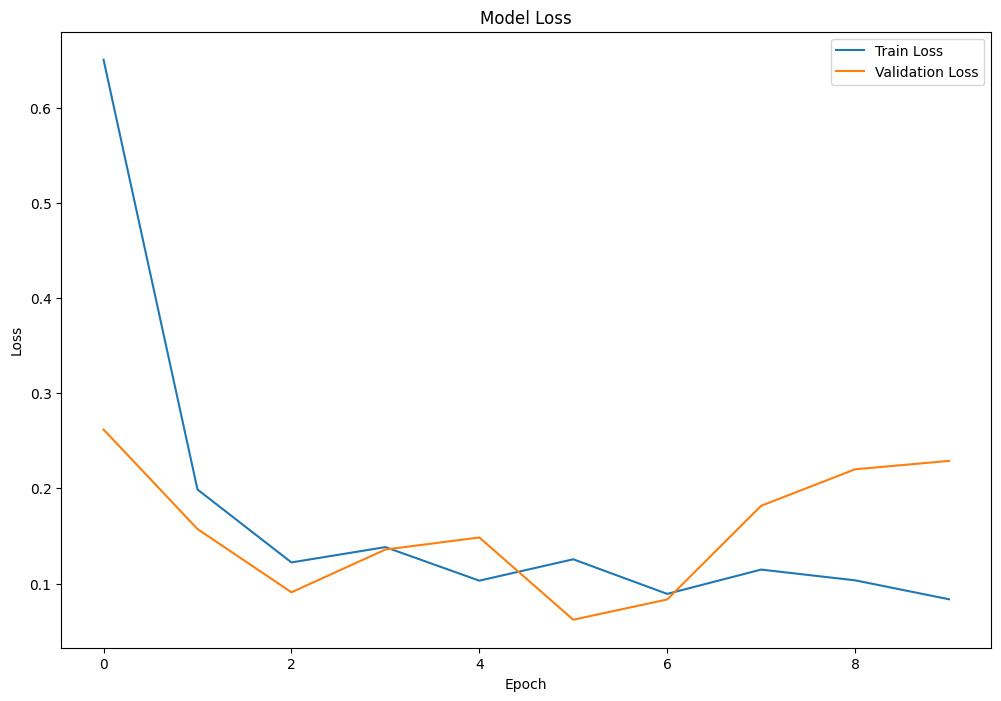

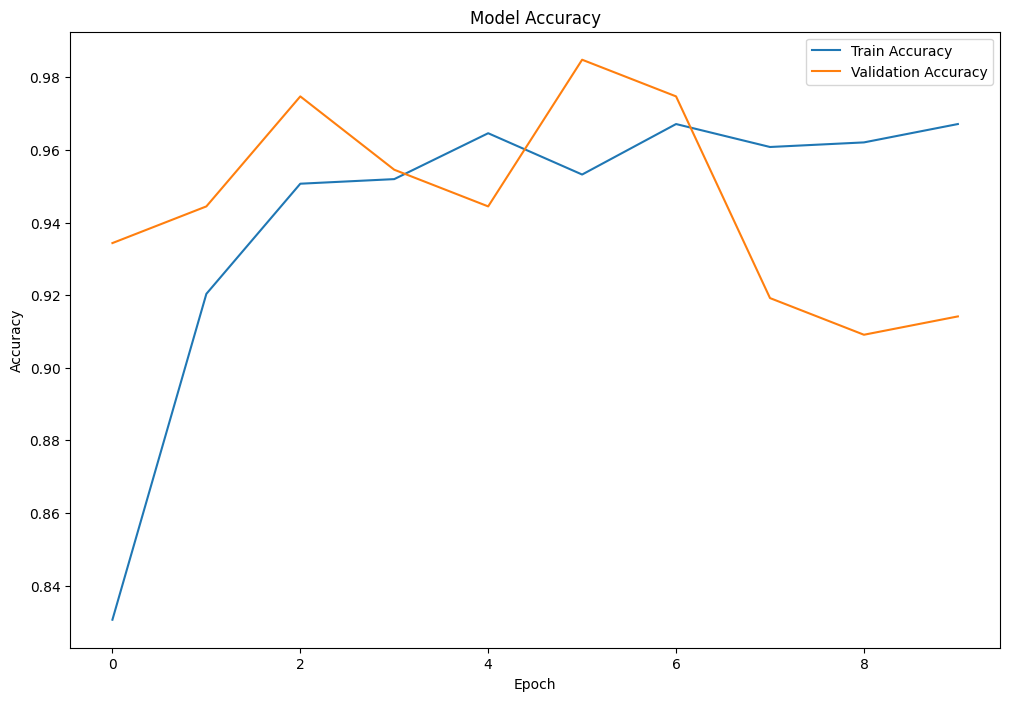

In [ ]:
# Plot training and validation loss and accuracy
def plot_training_history(history):
    # Plot loss
    plt.figure(figsize=(12, 8))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(12, 8))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_training_history(history)


*   8.2 Confusion Matrix

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


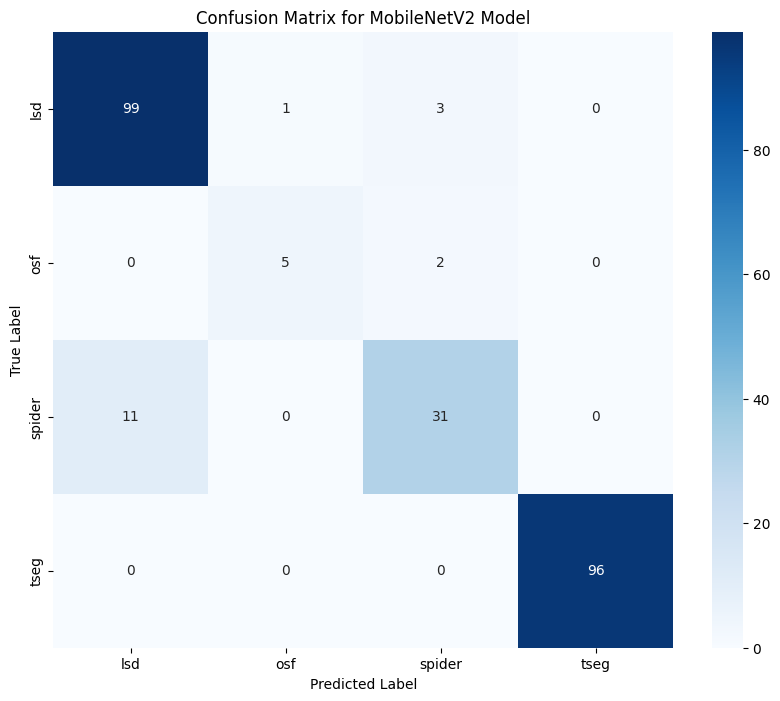

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Helper function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Generate and plot confusion matrix for the model
y_pred = np.argmax(mobilenet_model.predict(X_test), axis=1)
plot_confusion_matrix(y_test, y_pred, class_names, title='Confusion Matrix for MobileNetV2 Model')


In [ ]:
# Evaluate the model on the training and test datasets
train_eval = mobilenet_model.evaluate(X_train, y_train, verbose=1)
test_eval = mobilenet_model.evaluate(X_test, y_test, verbose=1)

print(f"Training Loss: {train_eval[0]}, Training Accuracy: {train_eval[1]}")
print(f"Test Loss: {test_eval[0]}, Test Accuracy: {test_eval[1]}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9840 - loss: 0.0575
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9416 - loss: 0.1468
Training Loss: 0.05730506777763367, Training Accuracy: 0.9860935807228088
Test Loss: 0.1571539342403412, Test Accuracy: 0.9314516186714172
